In [26]:
import numpy as np
# import joblib
import cv2
import os
import sys
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [27]:
src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Data Preparation

In [8]:
dataset_dir = "../data/faces_nofaces"

In [9]:
batch_size = 32
img_size = (64, 64)

dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',  # 0 = Face, 1 = NoFace
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

val_dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 1410 files belonging to 2 classes.
Using 1128 files for training.
Found 1410 files belonging to 2 classes.
Using 282 files for validation.


In [10]:
dataset.class_names

['Faces', 'NoFaces']

In [11]:
def dataset_to_tensor(dataset):
    images = []
    labels = []
    for imgs, lbls in dataset:
        images.append(imgs)
        labels.append(lbls)
    x = tf.concat(images, axis=0)
    y = tf.concat(labels, axis=0)
    return x, y

In [12]:
x_train, y_train = dataset_to_tensor(dataset)
x_val, y_val = dataset_to_tensor(val_dataset)

2025-04-10 19:15:37.505637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-10 19:15:38.258115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
x_train_flat = tf.reshape(x_train, (x_train.shape[0], -1)) / 255.0
x_val_flat = tf.reshape(x_val, (x_val.shape[0], -1)) / 255.0

In [14]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_flat)
x_val_scaled = scaler.transform(x_val_flat)

# SVM

In [15]:
print("Training SVM...")
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_scaled, y_train)

Training SVM...


SVC(kernel='linear')

In [16]:
y_pred = svm_model.predict(x_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.7659574468085106
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       115
           1       0.80      0.80      0.80       167

    accuracy                           0.77       282
   macro avg       0.76      0.76      0.76       282
weighted avg       0.77      0.77      0.77       282



In [ ]:
# joblib.dump(svm_model, 'svm_model.joblib')

# Random Forest

In [17]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_scaled, y_train)

Training Random Forest...


RandomForestClassifier(random_state=42)

In [18]:
y_pred = rf_model.predict(x_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.7978723404255319
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       115
           1       0.85      0.80      0.82       167

    accuracy                           0.80       282
   macro avg       0.79      0.80      0.79       282
weighted avg       0.80      0.80      0.80       282



In [19]:
# joblib.dump(rf_model, 'rf_model.joblib')

# KNN

In [20]:
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_scaled, y_train)

Training KNN...


KNeighborsClassifier(n_neighbors=3)

In [21]:
y_pred = knn_model.predict(x_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8049645390070922
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.64      0.73       115
           1       0.79      0.92      0.85       167

    accuracy                           0.80       282
   macro avg       0.81      0.78      0.79       282
weighted avg       0.81      0.80      0.80       282



In [22]:
# joblib.dump(knn_model, 'knn_model.joblib')

# Results Comparison

In [28]:
from image_loader import load_image, show_image

In [49]:
def classify_image_with_algorithms(img_path, models, model_names, scaler, image_size=(64, 64)):
    img = load_image(img_path)
    # img_resized = cv2.resize(img, image_size)

    img_arr = (cv2.resize(img, image_size) / 255.0).flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_arr)

    label_map = {0: "Face", 1: "Not Face"}

    # print(f"\nResults for image: {img_path}")
    show_image(img)

    for model, name in zip(models, model_names):
        prediction = model.predict(img_scaled)[0]
        print(f"{name:<18} {label_map[prediction]:<15}")


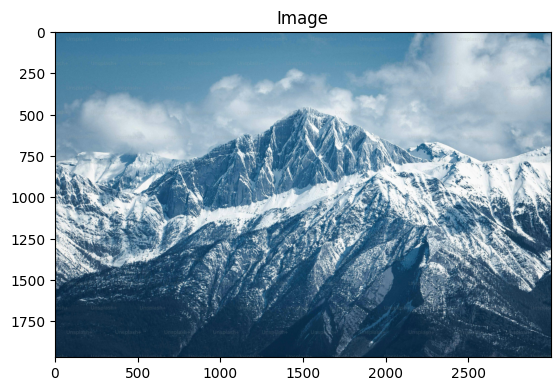

SVM                Not Face       
Random Forest      Not Face       
KNN                Not Face       


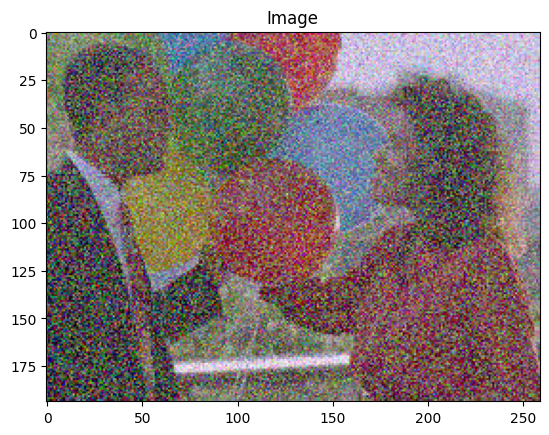

SVM                Not Face       
Random Forest      Not Face       
KNN                Not Face       


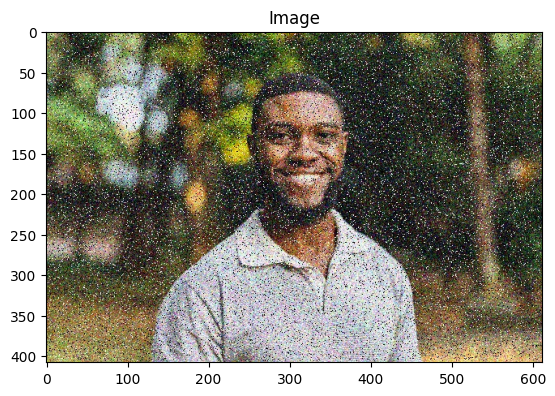

SVM                Face           
Random Forest      Not Face       
KNN                Face           


In [50]:
models = [svm_model, rf_model, knn_model]
model_names = ["SVM", "Random Forest", "KNN"]

img_paths = ["../data/2__images/mountains.jpeg", "../data/2__images/holiday.jpeg", "../data/2__images/man_noisy.jpg"]
for i in img_paths:
    classify_image_with_algorithms(i, models, model_names, scaler, image_size=(64, 64))